<!-- # Overview
- Project
    - data engineer 
        - keep acceptable sessions
        - create prediction classes and eliminate end of each session
        - make same input size for rnn
        - add features if this is suitable
    - code each rnn
        - vanilla rnn
        - lstm
        - gru -->

# Overview
- Load Data
    - 
- Modelling
    - Train-Test-Split
    - RNN
        - Model Def
        - Model Training
    - LSTM
        - Model Def
        - Model Training
    - GRU
        - Model Def
        - Model Training
    - (Transformer Model Def)
        - Transfer Learning/Model Def
        - Model Training
        
- Evaluation and Comparison of Models
    - Numerical Evalutaion Metrics
        - AUC and F1 Score
       - (Plotting number results comparing each as parameters change)
    - Plotted Evaluation Metrics
        - ROC Curve

# Imports

In [16]:
# manipulating data
import numpy as np

# 
from sklearn.utils.class_weight import compute_class_weight

# Neural Networks
import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim

# Custom Metrics and Evaluation
from metrics import bin_class_metrics, multiclass_metrics, evaluate_model_metrics, print_metrics, PlotLoss
from ModelDefinitions import RNNClassifier, LSTMClassifier, GRUClassifier
from TrainFunctions import create_file, load_data, getDataloaders, train_model

# handling time data
import time # for counting time for something to run

# plotting
import matplotlib.pyplot as plt 

# handling files
import os


# Modelling

####
- https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm

- There's one additional rule of thumb that helps for supervised learning problems. You can usually prevent over-fitting if you keep your number of neurons below:

𝑁ℎ=𝑁𝑠(𝛼∗(𝑁𝑖+𝑁𝑜))

- 𝑁𝑖 = number of input neurons.
- 𝑁𝑜 = number of output neurons.
- 𝑁𝑠 = number of samples in training data set.
- 𝛼 = an arbitrary scaling factor usually 2-10.

Guy says he geneerally uses 2

#### https://www.reddit.com/r/MachineLearning/comments/4behuh/does_the_number_of_layers_in_an_lstm_network/
Some discussion about what "depth" in recurrent architectures means. Downward skip-connections seem to be the most helpful, but in general skip connections are critical in deep recurrent networks.

#### 
- https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
- usually one hidden layer is fine

### This looks like best tutorial to follow so far (in an article)
- https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
- https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-rnn-for-text-classification-tasks
    - didn't look bad either
- https://docs.wandb.ai/guides/integrations/pytorch
    - logging gradients with wandb

### Youtube Tutorial - Just Like Best One up There
- https://www.youtube.com/watch?v=1vGOQAel2yU&ab_channel=SungKim
- packed sequence

# Model Definitions
#### Training Function
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
    - training with validation as well

## Hyperparameter Tuning
- https://medium.com/distributed-computing-with-ray/scaling-up-pytorch-lightning-hyperparameter-tuning-with-ray-tune-4bd9e1ff9929- 

## Early Stopping
- https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

### Global Parameters

In [17]:
# select GPU / CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


## Train RNN

In [22]:
# parameters
model_name = "vanilla_rnn"
output_size = 3
b = 64 # batch size
h = 64 # hidden size
d = 0  # dropout
learning_rate = 0.001
bias = True

train_dataset, test_dataset = load_data(output_size)

train_dataloader, val_dataloader, test_dataloader = getDataloaders(train_dataset, test_dataset, b)

class_weights=compute_class_weight('balanced',classes = np.unique(train_dataset[:][1]), y = train_dataset[:][1].numpy().reshape(-1))
class_weights=torch.tensor(class_weights,dtype=torch.float)

path = create_file(model_name, output_size, hidden_size, batch_size)

# instantiate model
rnn = RNNClassifier(input_size, h, output_size, n_layers, d, bias).to(device)
rnn = nn.DataParallel(rnn)

loss_fn_rnn = torch.nn.CrossEntropyLoss() # weight = class_weights
torch.set_default_tensor_type(torch.FloatTensor)

optimizer_rnn = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

rnn_val_loss_tot = []
rnn_train_loss_tot = []


In [23]:
# train
num_epochs = 6
rnn, rnn_train_loss, rnn_val_loss = train_model(rnn, loss_fn_rnn, optimizer_rnn, num_epochs, train_dataloader, val_dataloader, 2, path, device, False)



[0/6] train_loss: 0.17850 valid_loss: 0.17192
Validation loss decreased (inf --> 0.171924).  Saving model ...
[1/6] train_loss: 0.17213 valid_loss: 0.17207
EarlyStopping counter: 1 out of 2
[2/6] train_loss: 0.17240 valid_loss: 0.17223
EarlyStopping counter: 2 out of 2
[3/6] train_loss: 0.17230 valid_loss: 0.17200
EarlyStopping counter: 3 out of 2
[4/6] train_loss: 0.17219 valid_loss: 0.17201
EarlyStopping counter: 4 out of 2
[5/6] train_loss: 0.17223 valid_loss: 0.17193
EarlyStopping counter: 5 out of 2
Finished Training


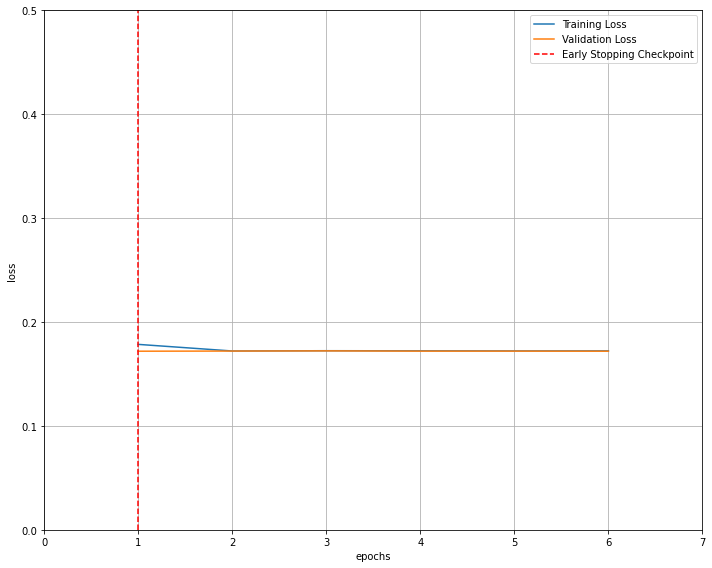

In [24]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(rnn_train_loss)+1),rnn_train_loss, label='Training Loss')
plt.plot(range(1,len(rnn_val_loss)+1),rnn_val_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = rnn_val_loss.index(min(rnn_val_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(rnn_train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [25]:
print("-----------------------------------------------------------------------------------")
print("RNN Metrics")
print("Train")
preds_rnn_train = evaluate_model_metrics(rnn, 2, train_dataloader)

print("Test")
preds_rnn = evaluate_model_metrics(rnn, 2, test_dataloader)
print("-----------------------------------------------------------------------------------")

-----------------------------------------------------------------------------------
RNN Metrics
Train
Confusion Matrix (0 in Top Left): 
tensor([[124640,      0],
        [  5361,      0]])


precision is nan (has been set to 0)
recall is nan (has been set to 0)
F1score is nan (has been set to 0)


Precision:  0
Recall:  0
F1-Score:  0
Test
Confusion Matrix (0 in Top Left): 
tensor([[38955,     0],
        [ 1670,     0]])


precision is nan (has been set to 0)
recall is nan (has been set to 0)
F1score is nan (has been set to 0)


Precision:  0
Recall:  0
F1-Score:  0
-----------------------------------------------------------------------------------


#### Train LSTM

In [ ]:
hidden_size = [32, 64, 128, 256]
batch_size = [32, 64, 128, 256]


output_size = 3

# datasets
data_path = "./cleaned_data"
trainset_path = "/train_dataset_{}.pt".format(output_size)
testset_path = "/test_dataset_{}.pt".format(output_size)
train_dataset = torch.load(data_path + trainset_path)
test_dataset = torch.load(data_path + testset_path)

num_epochs = 15
lstm_train_loss_tot = []

for h in hidden_size:
    for b in batch_size:
        # dataloaders
        train_dataloader, val_dataloader, test_dataloader = getDataloaders(train_dataset, test_dataset, b)
        
        # model parameters for instantiation
        weights = torch.FloatTensor([0.05, 0.95])
        path = "./model_checkpoints/lstm/output{}/hidden={}&batch={}/checkpoint.pt".format(output_size,h, b)
        
        isExist = os.path.exists(path)
        if not isExist:
           # Create a new directory because it does not exist
           os.makedirs(path)

        #instantiate model
        lstm = LSTMClassifier(input_size, h, output_size, n_layers)

        loss_fn_lstm = torch.nn.CrossEntropyLoss() # SHOULD USE WEIGHT PARAMETER SINCE UNBALANCED
        learning_rate = 0.001

        optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
        
        # train
        lstm, lstm_train_loss, lstm_val_loss = train_model(lstm, loss_fn_lstm, optimizer_lstm, num_epochs, train_dataloader, val_dataloader, 2, path)
        lstm_train_loss_tot.append(lstm_train_loss)




In [27]:
# parameters
model_name = "lstm"
output_size = 3
b = 64 # batch size
h = 64 # hidden size
learning_rate = 0.001
bias = True
d = 0

train_dataset, test_dataset = load_data(output_size)

train_dataloader, val_dataloader, test_dataloader = getDataloaders(train_dataset, test_dataset, b)

class_weights=compute_class_weight('balanced',classes = np.unique(train_dataset[:][1]), y = train_dataset[:][1].numpy().reshape(-1))
class_weights=torch.tensor(class_weights,dtype=torch.float)

path = create_file(model_name, output_size, hidden_size, batch_size)

# instantiate model
lstm = LSTMClassifier(input_size, h, output_size, n_layersd, bias).to(device)
lstm = nn.DataParallel(lstm)

loss_fn_lstm = torch.nn.CrossEntropyLoss() # weight = class_weights
torch.set_default_tensor_type(torch.FloatTensor)

optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

lstm_val_loss_tot = []
lstm_train_loss_tot = []


In [31]:
# train
num_epochs = 5
lstm, lstm_train_loss, lstm_val_loss = train_model(lstm, loss_fn_lstm, optimizer_lstm, num_epochs, train_dataloader, val_dataloader, 2, path, device, False)
lstm_val_loss_tot.append(lstm_val_loss)
lstm_train_loss_tot.append(lstm_train_loss)


[ 0/10] train_loss: 0.04810 valid_loss: 0.04819
Validation loss decreased (inf --> 0.048195).  Saving model ...
[ 1/10] train_loss: 0.04610 valid_loss: 0.04873
EarlyStopping counter: 1 out of 2
[ 2/10] train_loss: 0.04515 valid_loss: 0.04592
Validation loss decreased (0.048195 --> 0.045922).  Saving model ...
[ 3/10] train_loss: 0.04418 valid_loss: 0.04629
EarlyStopping counter: 1 out of 2
[ 4/10] train_loss: 0.04438 valid_loss: 0.04671
EarlyStopping counter: 2 out of 2
[ 5/10] train_loss: 0.04299 valid_loss: 0.04474
Validation loss decreased (0.045922 --> 0.044741).  Saving model ...
[ 6/10] train_loss: 0.04244 valid_loss: 0.04667
EarlyStopping counter: 1 out of 2
[ 7/10] train_loss: 0.04176 valid_loss: 0.05949
EarlyStopping counter: 2 out of 2
[ 8/10] train_loss: 0.04224 valid_loss: 0.04248
Validation loss decreased (0.044741 --> 0.042485).  Saving model ...
[ 9/10] train_loss: 0.04049 valid_loss: 0.04400
EarlyStopping counter: 1 out of 2
Finished Training


In [ ]:
PlotLoss(gru_train_loss, gru_val_loss, model_name)

In [ ]:
print_metrics(gru, model_name, output_size, train_dataloader, test_dataloader)

#### Train GRU

In [86]:
hidden_size = [64, 128, 256]
batch_size = [32, 64, 128, 256]

output_size = 3

# datasets
data_path = "./cleaned_data"
trainset_path = "/train_dataset_{}.pt".format(output_size)
testset_path = "/test_dataset_{}.pt".format(output_size)
train_dataset = torch.load(data_path + trainset_path)
test_dataset = torch.load(data_path + testset_path)

num_epochs = 40
gru_val_loss_tot = []

for h in hidden_size:
    for b in batch_size:
        print("Hidden_size: {}, Batch_size: {}".format(h, b))
      
        # dataloaders
        train_dataloader, val_dataloader, test_dataloader = getDataloaders(train_dataset, test_dataset, b)
        
        # model parameters for instantiation
        weights = torch.FloatTensor([0.95, 0.05])
        
        dir_path = "./model_checkpoints/gru/output{}/hidden={}&batch={}".format(output_size, h, b)
        isExist = os.path.exists(dir_path)
        if not isExist:
           # Create a new directory because it does not exist
           os.makedirs(dir_path)
            
        f = open(dir_path + "/checkpoint.pt", 'w')
        f.close()
        
        path = dir_path + "/checkpoint.pt"

        #instantiate model
        gru = GRUClassifier(input_size, h, output_size, n_layers)

        loss_fn_gru = torch.nn.CrossEntropyLoss(weights)
        learning_rate = 0.001

        optimizer_gru = torch.optim.Adam(gru.parameters(), lr=learning_rate)
        
        # train
        gru, gru_train_loss, gru_val_loss = train_model(gru, loss_fn_gru, optimizer_gru, num_epochs, train_dataloader, val_dataloader, 2, path)
        gru_val_loss_tot.append(gru_train_loss)




Hidden_size: 32, Batch_size: 32
[ 0/15] train_loss: 0.45058 valid_loss: 0.15823
Validation loss decreased (inf --> 0.158235).  Saving model ...
[ 1/15] train_loss: 0.14978 valid_loss: 0.13519
Validation loss decreased (0.158235 --> 0.135190).  Saving model ...
[ 2/15] train_loss: 0.13608 valid_loss: 0.12770
Validation loss decreased (0.135190 --> 0.127696).  Saving model ...
[ 3/15] train_loss: 0.12927 valid_loss: 0.11555
Validation loss decreased (0.127696 --> 0.115553).  Saving model ...
[ 4/15] train_loss: 0.10157 valid_loss: 0.09234
Validation loss decreased (0.115553 --> 0.092343).  Saving model ...
[ 5/15] train_loss: 0.09202 valid_loss: 0.08684
Validation loss decreased (0.092343 --> 0.086837).  Saving model ...
[ 6/15] train_loss: 0.08998 valid_loss: 0.08330
Validation loss decreased (0.086837 --> 0.083297).  Saving model ...
[ 7/15] train_loss: 0.08264 valid_loss: 0.07582
Validation loss decreased (0.083297 --> 0.075815).  Saving model ...
[ 8/15] train_loss: 0.07767 valid_los

[13/15] train_loss: 0.04955 valid_loss: 0.05024
Validation loss decreased (0.059205 --> 0.050235).  Saving model ...
[14/15] train_loss: 0.04516 valid_loss: 0.04529
Validation loss decreased (0.050235 --> 0.045290).  Saving model ...
Finished Training
Hidden_size: 64, Batch_size: 64
[ 0/15] train_loss: 0.57805 valid_loss: 0.22175
Validation loss decreased (inf --> 0.221746).  Saving model ...
[ 1/15] train_loss: 0.17030 valid_loss: 0.13525
Validation loss decreased (0.221746 --> 0.135252).  Saving model ...
[ 2/15] train_loss: 0.11339 valid_loss: 0.10278
Validation loss decreased (0.135252 --> 0.102781).  Saving model ...
[ 3/15] train_loss: 0.09461 valid_loss: 0.09082
Validation loss decreased (0.102781 --> 0.090822).  Saving model ...
[ 4/15] train_loss: 0.08829 valid_loss: 0.08686
Validation loss decreased (0.090822 --> 0.086864).  Saving model ...
[ 5/15] train_loss: 0.08318 valid_loss: 0.07913
Validation loss decreased (0.086864 --> 0.079130).  Saving model ...
[ 6/15] train_loss:

[11/15] train_loss: 0.06762 valid_loss: 0.06903
EarlyStopping counter: 1 out of 2
[12/15] train_loss: 0.06326 valid_loss: 0.06103
Validation loss decreased (0.068279 --> 0.061026).  Saving model ...
[13/15] train_loss: 0.07480 valid_loss: 0.12177
EarlyStopping counter: 1 out of 2
[14/15] train_loss: 0.09244 valid_loss: 0.08006
EarlyStopping counter: 2 out of 2
Finished Training
Hidden_size: 128, Batch_size: 128
[ 0/15] train_loss: 0.80905 valid_loss: 0.64453
Validation loss decreased (inf --> 0.644526).  Saving model ...
[ 1/15] train_loss: 0.32721 valid_loss: 0.21451
Validation loss decreased (0.644526 --> 0.214511).  Saving model ...
[ 2/15] train_loss: 0.17814 valid_loss: 0.15217
Validation loss decreased (0.214511 --> 0.152174).  Saving model ...
[ 3/15] train_loss: 0.12423 valid_loss: 0.10216
Validation loss decreased (0.152174 --> 0.102155).  Saving model ...
[ 4/15] train_loss: 0.10147 valid_loss: 0.09178
Validation loss decreased (0.102155 --> 0.091775).  Saving model ...
[ 5/1

KeyboardInterrupt: 

In [ ]:
hid = [32, 32, 32, 32, 64, 64, 64, 64, 128, 128, 128, 128]
bat = [32, 64,128, 256, 32, 64,128, 256, 32, 64,128, 256]
output_size = 3


for i, h in enumerate(hid):
    print("Hidden: {}, Batch: {}".format(h, bat[i]))
    path = "./model_checkpoints/gru/output{}/hidden={}&batch={}/checkpoint.pt".format(output_size, h, bat[i])
    gru = GRUClassifier(input_size, h, output_size, n_layers)
    gru.load_state_dict(torch.load(path))
    preds_gru = evaluate_model_metrics(gru, output_size, test_dataloader)
    print("-----------------------------------------------------------------------------------")

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers = 1, dropout = 0, bias = False):
        super(GRUClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        # self.embedding = (input_size, hidden_size)
        
        # input_size might need to be hidden_size as well
        self.gru = torch.nn.GRU(input_size, hidden_size, batch_first = True, dropout = dropout, bias = bias)
        self.drop = torch.nn.Dropout(dropout)
        # MAYBE NEED TO ADD ANOTHER LINEAR LAYER
        self.linear = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, sequences):

        batch_size = sequences.size(0)
    
        #embedded = self.embedding(sequence)
#         print(sequences.shape)
        
        hidden = self._init_hidden(batch_size)
        out, hidden = self.gru(sequences, hidden) # embedded here for sequence if not commented out
        out = self.drop(hidden[-1])
            
        out = self.linear(out)
    
        return out, hidden
    
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)

In [55]:
# choose which problem to solve
output_size = 3

# get datasets
train_dataset, test_dataset = load_data(output_size)

# parameters
input_size = len(train_dataset[0][0][0])
n_layers = 1
model_name = "gru"
b = 64 # batch size
h = 64 # hidden size
learning_rate = 0.001
bias = True
d = 0.3

# get class weights for imbalanced datasets
y = train_dataset[:][1]
class_weights=compute_class_weight('balanced',classes = np.unique(y), y = y.numpy().reshape(-1))
class_weights=torch.tensor(class_weights,dtype=torch.float)

# create path to store checkpoints
path = create_file(model_name, output_size, h, b)

# get dataloaders
train_dataloader, val_dataloader, test_dataloader = getDataloaders(train_dataset, test_dataset, b)

# instantiate model
gru = GRUClassifier(input_size, h, output_size, n_layers, d, bias).to(device)
gru = nn.DataParallel(gru)

loss_fn_gru = torch.nn.CrossEntropyLoss() # weight = class_weights
torch.set_default_tensor_type(torch.FloatTensor)

optimizer_gru = torch.optim.Adam(gru.parameters(), lr=learning_rate)

gru_val_loss_tot = []
gru_train_loss_tot = []


In [65]:
start_time = time.time()
# train
num_epochs = 6
gru, gru_train_loss, gru_val_loss = train_model(gru, loss_fn_gru, optimizer_gru, num_epochs, train_dataloader, val_dataloader, 2, path, device, False)
gru_val_loss_tot.append(gru_val_loss)
gru_train_loss_tot.append(gru_train_loss)

print("--- %s seconds ---" % (time.time() - start_time))


[0/6] train_loss: 0.05331 valid_loss: 0.05278
Validation loss decreased (inf --> 0.052784).  Saving model ...
[1/6] train_loss: 0.05601 valid_loss: 0.05143
Validation loss decreased (0.052784 --> 0.051430).  Saving model ...
[2/6] train_loss: 0.05731 valid_loss: 0.05664
EarlyStopping counter: 1 out of 2
[3/6] train_loss: 0.05498 valid_loss: 0.05098
Validation loss decreased (0.051430 --> 0.050980).  Saving model ...
[4/6] train_loss: 0.05007 valid_loss: 0.04937
Validation loss decreased (0.050980 --> 0.049372).  Saving model ...
[5/6] train_loss: 0.04859 valid_loss: 0.04858
Validation loss decreased (0.049372 --> 0.048582).  Saving model ...
Finished Training
--- 1973.1141698360443 seconds ---


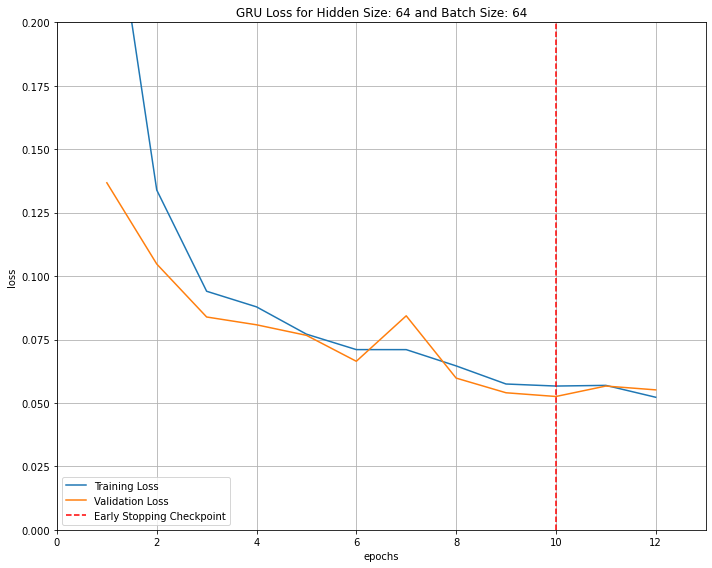

In [64]:
gru_train_loss_tot = [item for sublist in gru_train_loss_tot for item in sublist]
gru_val_loss_tot = [item for sublist in gru_val_loss_tot for item in sublist]

PlotLoss(gru_train_loss_tot, gru_val_loss_tot, model_name)

In [66]:
print_metrics(gru, model_name, output_size, train_dataloader, test_dataloader)

-----------------------------------------------------------------------------------
GRU  Metrics
Train
Confusion Matrix (0 in Top Left): 
tensor([[105249,     34,    163],
        [     6,  18073,   1130],
        [   642,    322,   4382]])
F1-Score (Average) tensor(0.9172)
F1-Score (each):
Class  0 : tensor(0.9960)
Class  1 : tensor(0.9604)
Class  2 : tensor(0.7952)
Test
Confusion Matrix (0 in Top Left): 
tensor([[32844,     8,    61],
        [    5,  5722,   315],
        [  176,   156,  1338]])
F1-Score (Average) tensor(0.9155)
F1-Score (each):
Class  0 : tensor(0.9962)
Class  1 : tensor(0.9594)
Class  2 : tensor(0.7908)
-----------------------------------------------------------------------------------


In [ ]:
ModelNames = ["gru", "lstm", "vanilla_rnn"]
ModelInstantiators = [GRUClassifier, LSTMClassifier, RNNClassifier]

# choose which problem to solve
output_size = 3

# get datasets
train_dataset, test_dataset = load_data(output_size)

# parameters
input_size = len(train_dataset[0][0][0])
n_layers = 1
bias = False
learning_rate = 0.001
num_epochs = 35

# hyperparameters to tune
hidden_size = [64, 128, 256]
batch_size = [32, 64, 128, 256]
dropout = [0, 0.2, 0.3, 0.4]

for ind, Classifier in enumerate(ModelInstantiators):
    print("------------------------------------------------------------")
    print(ModelNames[ind].upper())
    print("------------------------------------------------------------")

    model_name = ModelNames[ind]

    # get class weights for imbalanced datasets
    y = train_dataset[:][1]
    class_weights=compute_class_weight('balanced',classes = np.unique(y), y = y.numpy().reshape(-1))
    class_weights=torch.tensor(class_weights,dtype=torch.float)

    # store all losses, models for evaluation
    model_val_loss_tot = []
    model_train_loss_tot = []
    model_tot = []
    hyperparams_tot = []

    # train model on hyperparameters
    for h in hidden_size:
        for b in batch_size:
            for d in dropout:

                hyperparams = {"hidden_size": h, "batch_size": b, "dropout": d}
                hyperparams_tot.append(hyperparams)

                # create path to store checkpoints
                path = create_file(model_name, output_size, h, b, d)

                # get dataloaders
                train_dataloader, val_dataloader, test_dataloader = getDataloaders(train_dataset, test_dataset, b)

                # instantiate model
                model = Classifier(input_size, h, output_size, n_layers, d, bias).to(device)
                model = nn.DataParallel(model)

                loss_fn = torch.nn.CrossEntropyLoss() # weight = class_weights
                torch.set_default_tensor_type(torch.FloatTensor)

                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                start_time = time.time()
                # train
                model, model_train_loss, model_val_loss = train_model(model, loss_fn, optimizer, num_epochs, train_dataloader, val_dataloader, 2, path, device, False)
                model_tot.append(model)
                model_val_loss_tot.append(model_val_loss)
                model_train_loss_tot.append(model_train_loss)

                print("--- %s seconds ---" % (time.time() - start_time))

    # get all f1 scores
    f1_score_avg_tot = []
    f1_score_each_tot = []
    for m in model_tot:
        f1_score_avg, f1_score_each = print_metrics(m, model_name, output_size, train_dataloader, test_dataloader)
        f1_score_avg_tot.append(f1_score_avg)
        f1_score_each_tot.append(f1_score_each)

    max_f1_score_avg = 0
    max_ind_avg = 0
    max_f1_score_each_buy = 0
    max_ind_each = 0
    for i, f in enumerate(f1_score_avg_tot):
        if (f > max_f1_score_avg):
            max_f1_score_avg = f
            max_ind_avg = i
        for j, ff in enumerate(f1_score_each_tot[i]):
            if (ff > max_f1_score_each_buy):
                max_f1_score_each_buy = ff
                max_ind_each = j

    best_hyperparams_avg = hyperparams_tot[max_ind_avg]
    best_hyperparams_each = hyperparams_tot[max_ind_each]

    print("Best Score Avg F1: ", max_f1_score_avg)
    print("Best Hyperparams Avg F1: ", best_hyperparams_avg)
    print("Best Score Each F1: ", max_f1_score_each_buy)
    print("Best Hyperparams Each F1: ", best_hyperparams_each)
    print("\n\n")


In [ ]:
output_size = 3

# datasets
data_path = "./cleaned_data"
trainset_path = "/train_dataset_{}.pt".format(output_size)
testset_path = "/test_dataset_{}.pt".format(output_size)
train_dataset = torch.load(data_path + trainset_path)
test_dataset = torch.load(data_path + testset_path)

num_epochs = 40
gru_val_loss_tot = []

for h in hidden_size:
    for b in batch_size:
        print("Hidden_size: {}, Batch_size: {}".format(h, b))
      
        # dataloaders
        train_dataloader, val_dataloader, test_dataloader = getDataloaders(train_dataset, test_dataset, b)
        
        # model parameters for instantiation
        weights = torch.FloatTensor([0.95, 0.05])
        
        dir_path = "./model_checkpoints/gru/output{}/hidden={}&batch={}".format(output_size, h, b)
        isExist = os.path.exists(dir_path)
        if not isExist:
           # Create a new directory because it does not exist
           os.makedirs(dir_path)
            
        f = open(dir_path + "/checkpoint.pt", 'w')
        f.close()
        
        path = dir_path + "/checkpoint.pt"

        #instantiate model
        gru = GRUClassifier(input_size, h, output_size, n_layers)

        loss_fn_gru = torch.nn.CrossEntropyLoss(weights)
        learning_rate = 0.001

        optimizer_gru = torch.optim.Adam(gru.parameters(), lr=learning_rate)
        
        # train
        gru, gru_train_loss, gru_val_loss = train_model(gru, loss_fn_gru, optimizer_gru, num_epochs, train_dataloader, val_dataloader, 2, path)
        gru_val_loss_tot.append(gru_train_loss)




In [ ]:
num_epochs = 3

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #labels = labels.long() # convert to expected target datatype (Long which is equivalent to int here)
        labels = labels.type(torch.LongTensor)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, h = gru(inputs)
        
#         outputs = outputs[:,154,0:2]
        loss = loss_fn_gru(outputs,labels.view(-1).long()) # do i need to fix what's in here (even necessary to have it)
#         loss = loss_fn(outputs, labels.reshape(-1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
        

print('Finished Training')